# Week 5.2 Assignment
- Joshua Burden
- Bellevue University
- DSC550 Data Mining
- Dr. Brett Werner
- 10/02/2022

# You will build a model with the movie reviews dataset that you worked with in Week 3: Bag of Words Meets Bags of Popcorn. 


In [1]:
#IMPORTS
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt


Get the stemmed data using the same process you did in Week 3.


In [2]:


df = pd.read_csv('./DATA/labeledTrainData.tsv/labeledTrainData.tsv', sep="\t")
df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [3]:
df_reviews_preprocessed = pd.DataFrame(df[['sentiment','review']])
df_reviews_preprocessed.head()

,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


In [4]:
def clean_text(text):
    """
    Remove punctuations and special characters, makes lower case
    Args: text 
    Output: text
    """    
    text=text.lower() #makes text lowercase
    text=re.sub('\\d|\\W+|_',' ',text) #removes extra white space
    text=re.sub('[^a-zA-Z0-9]'," ", text) #removes any non-alphanumeric characters
    
    return text

In [5]:
def tokenize_and_remove_stop_words(txt):
 
    from nltk.corpus import stopwords
 
    stop_words = stopwords.words('english')
    
    txt_token = word_tokenize(txt)
    txt_no_stopwords = [word for word in txt_token if word not in stop_words]
    
    return txt_no_stopwords

def stem_text(word_list):
    from nltk.stem.porter import PorterStemmer
    porter = PorterStemmer()
    return [porter.stem(word) for word in word_list]
#create new columns in the data frame for each preprocessing step
#apply text cleaning function
df_reviews_preprocessed['review_clean'] = df_reviews_preprocessed['review'].apply(clean_text)
df_reviews_preprocessed['review_tokenized'] = df_reviews_preprocessed['review_clean'].apply(tokenize_and_remove_stop_words)
df_reviews_preprocessed['review_stemmed'] = df_reviews_preprocessed['review_tokenized'].apply(stem_text)
df_reviews_preprocessed['review_final'] = df_reviews_preprocessed['review_stemmed'].apply(lambda text: ' '.join(text))
print(df_reviews_preprocessed.shape)
df_reviews_preprocessed.head()

(25000, 6)


,sentiment,review,review_clean,review_tokenized,review_stemmed,review_final
0,1,With all this stuff going down at the moment w...,with all this stuff going down at the moment w...,"[stuff, going, moment, mj, started, listening,...","[stuff, go, moment, mj, start, listen, music, ...",stuff go moment mj start listen music watch od...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi...",the classic war of the worlds by timothy hine...,"[classic, war, worlds, timothy, hines, enterta...","[classic, war, world, timothi, hine, entertain...",classic war world timothi hine entertain film ...
2,0,The film starts with a manager (Nicholas Bell)...,the film starts with a manager nicholas bell g...,"[film, starts, manager, nicholas, bell, giving...","[film, start, manag, nichola, bell, give, welc...",film start manag nichola bell give welcom inve...
3,0,It must be assumed that those who praised this...,it must be assumed that those who praised this...,"[must, assumed, praised, film, greatest, filme...","[must, assum, prais, film, greatest, film, ope...",must assum prais film greatest film opera ever...
4,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy and wondrously unpretentious ...,"[superbly, trashy, wondrously, unpretentious, ...","[superbl, trashi, wondrous, unpretenti, exploi...",superbl trashi wondrous unpretenti exploit hoo...


Split this into a training and test set.


In [7]:
x = df_reviews_preprocessed['review_final']
y = df_reviews_preprocessed['sentiment']
# Create training & test datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

Fit and apply the tf-idf vectorization to the training set.


In [8]:
tfidf = TfidfVectorizer()
tfidf_matrix_train = tfidf.fit_transform(x_train)

#  validate shape
tfidf_matrix_train.shape

(20000, 45205)

Apply but DO NOT FIT the tf-idf vectorization to the test set (Why?).


In [9]:
tfidf_matrix_test = tfidf.transform(x_test)

# Check the shape to validate
tfidf_matrix_test.shape


(5000, 45205)

#### Fitting the tf-idf vectorization in the test set would cause a leak from our test set to our model. We want to avoid this.

Train a logistic regression using the training data.


In [10]:
logistic_regression = LogisticRegression(random_state=0)

# Train model and make predictions
y_test_pred = logistic_regression.fit(tfidf_matrix_train, y_train).predict(tfidf_matrix_test)
y_test_pred

array([1, 0, 1, ..., 0, 0, 1], dtype=int64)

Find the model accuracy on test set.


In [11]:
print("Accuracy Rate: ", accuracy_score(y_test, y_test_pred))

Accuracy Rate:  0.8886


Create a confusion matrix for the test set predictions.


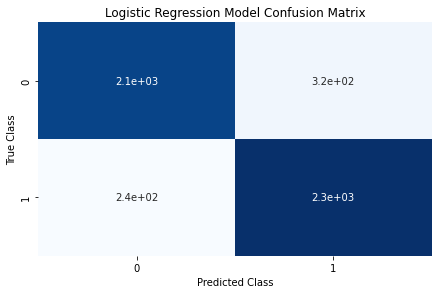

In [12]:
matrix = confusion_matrix(y_test, y_test_pred)

# Create pandas dataframe
df = pd.DataFrame(matrix)

# Create heatmap
sns.heatmap(df, annot=True, cbar=None, cmap="Blues")
plt.title("Logistic Regression Model Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

Get the precision, recall, and F1-score for the test set predictions.


In [13]:
# Calculate Precision
p = "{:.0%}".format(precision_score(y_test, y_test_pred))

# Calculate Recall
r = "{:.0%}".format(recall_score(y_test, y_test_pred))

# Calculate F1-score
f1 = "{:.0%}".format(f1_score(y_test, y_test_pred))

# Print results
print("Precision:",p)
print("Recall:",r)
print("F1-score:",f1)

Precision: 88%
Recall: 91%
F1-score: 89%


Create a ROC curve for the test set.


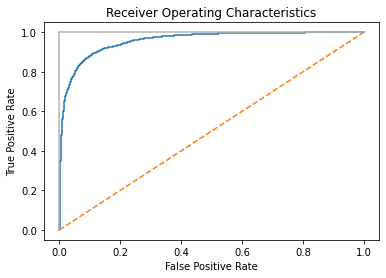

In [14]:
# Get predicted probabilities
target_probabilities = logistic_regression.predict_proba(tfidf_matrix_test)[:,1]

# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, target_probabilities)

# Plot ROC curve
plt.title("Receiver Operating Characteristics")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

Pick another classification model you learned about this week and repeat steps (5) – (9).

In [15]:
# Create random forest classifier object
randomforest = RandomForestClassifier(random_state=0, n_jobs=-1)

# Train model & predict
rf_model_pred = randomforest.fit(tfidf_matrix_train, y_train).predict(tfidf_matrix_test)

In [16]:
# Calculate accuracy
accuracy_score(y_test, rf_model_pred)

0.8528

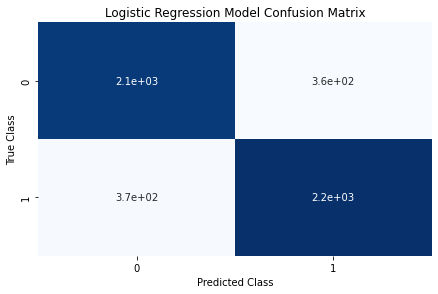

In [17]:
# Create confusion matrix
matrix_rf = confusion_matrix(y_test, rf_model_pred)

# Create pandas dataframe
df_rf = pd.DataFrame(matrix_rf)

# Create heatmap
sns.heatmap(df_rf, annot=True, cbar=None, cmap="Blues")
plt.title("Logistic Regression Model Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [18]:
# Calculate Precision
p_rf = "{:.0%}".format(precision_score(y_test, rf_model_pred))

# Calculate Recall
r_rf = "{:.0%}".format(recall_score(y_test, rf_model_pred))

# Calculate F1-score
f1_rf = "{:.0%}".format(f1_score(y_test, rf_model_pred))

# Print results
print("Precision:",p_rf)
print("Recall:",r_rf)
print("F1-score:",f1_rf)

Precision: 86%
Recall: 85%
F1-score: 86%


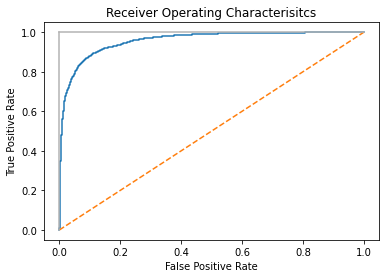

In [19]:
# Get predicted probabilities
target_probabilities_rf = randomforest.predict_proba(tfidf_matrix_test)[:,1]

# Create true and false positive rates
false_positive_rate_rf, true_positive_rate_rf, threshold_rf = roc_curve(y_test, target_probabilities)

# Plot ROC curve
plt.title("Receiver Operating Characterisitcs")
plt.plot(false_positive_rate_rf, true_positive_rate_rf)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()